# Evaluating When Vegetation Peaks in the City of Boulder versus Outside the City

In [ ]:
# Libraries 

import json
import os
import pathlib
from pathlib import Path


import earthpy
import hvplot.xarray
import rioxarray as rxr
import xarray as xr

import geopandas as gpd
import hvplot.pandas
import holoviews as hv


from glob import glob
import pandas as pd
from shapely.geometry import mapping
import matplotlib.pyplot as plt

### open street map
from osmnx import features as osm
import osmnx as ox

### earthpy
import earthpy
#import earthpy.api.appeears as eaapp

# Common statistical plots for tabular data
import seaborn as sns
# Fit an OLS linear regression
from sklearn.linear_model import LinearRegression
import numpy as np

<Axes: >

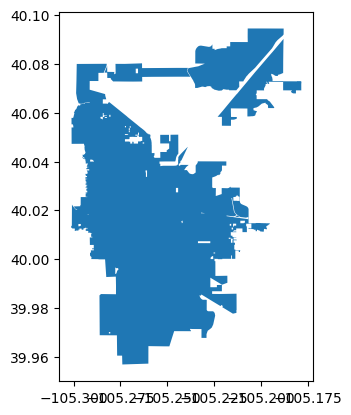

In [2]:
boulder_gdf = ox.geocode_to_gdf(
    'Boulder, Colorado, United States')

boulder_gdf

boulder_gdf.plot()

In [3]:
# Get a sorted list of NDVI tif file paths

ndvi_dir = Path("data/ndvi-boulder-2002-2022")

# Grab all matching files (recursively if needed)
ndvi_paths = sorted(ndvi_dir.rglob("MOD13Q1.061__250m_16_days_NDVI*.tif"))


# Display the first and last three files paths to check the pattern
ndvi_paths[:3], ndvi_paths[-3:]

([WindowsPath('data/ndvi-boulder-2002-2022/MOD13Q1.061__250m_16_days_NDVI_doy2002113000000_aid0001.tif'),
  WindowsPath('data/ndvi-boulder-2002-2022/MOD13Q1.061__250m_16_days_NDVI_doy2002129000000_aid0001.tif'),
  WindowsPath('data/ndvi-boulder-2002-2022/MOD13Q1.061__250m_16_days_NDVI_doy2002145000000_aid0001.tif')],
 [WindowsPath('data/ndvi-boulder-2002-2022/MOD13Q1.061__250m_16_days_NDVI_doy2022177000000_aid0001.tif'),
  WindowsPath('data/ndvi-boulder-2002-2022/MOD13Q1.061__250m_16_days_NDVI_doy2022193000000_aid0001.tif'),
  WindowsPath('data/ndvi-boulder-2002-2022/MOD13Q1.061__250m_16_days_NDVI_doy2022209000000_aid0001.tif')])

In [ ]:
ndvi_das = []

for ndvi_path in ndvi_paths:
    # Get date from file name
    fname = ndvi_path.name  # just the filename, not the whole path
    # find the substring "doy" and take the next 7 digits (YYYYDDD)
    doy_index = fname.find("doy") + 3
    date_str = fname[doy_index:doy_index + 7]  # e.g. '2001145'
    year = int(date_str[:4])
    doy = int(date_str[4:])
    date = pd.to_datetime(f"{year}-{doy}", format="%Y-%j")
    
    # Open dataset
    da = rxr.open_rasterio(ndvi_path, masked=True).squeeze()
    
    # Add date dimension and clean up metadata 
    da = da.assign_coords({'date': date}).expand_dims({'date': [date]})
    da.name = 'NDVI'
    
    # Prepare for concatenation
    ndvi_das.append(da)

ndvi_da = xr.combine_by_coords(ndvi_das, coords=['date'])

In [5]:
ndvi_da

<xarray.Dataset> Size: 31MB
Dimensions:      (date: 147, y: 169, x: 309)
Coordinates:
  * date         (date) datetime64[ns] 1kB 2002-04-23 2002-05-09 ... 2022-07-28
    band         int64 8B 1
  * x            (x) float64 2kB -105.7 -105.7 -105.7 ... -105.1 -105.1 -105.1
  * y            (y) float64 1kB 40.26 40.26 40.26 40.26 ... 39.92 39.92 39.91
    spatial_ref  int64 8B 0
Data variables:
    NDVI         (date, y, x) float32 31MB 278.0 278.0 ... 3.29e+03 3.29e+03

In [ ]:
ndvi_scaled = ndvi_da * 0.0001

difference_plot = (
    ndvi_scaled.hvplot(x='x', y='y', cmap='PiYG', geo=True, 
                            title='NVDI from 2002 to 2022', ylabel='Latitude', xlabel='Longitude')
    *
    boulder_gdf.hvplot(geo=True, fill_color=None, line_color='black') # add boundary
)

difference_plot

#hv.save(difference_plot, "rawNDVIimages_timeseries_map.html")

In [7]:
ndvi_clipped_in = ndvi_scaled.rio.clip(boulder_gdf.geometry.apply(mapping),
                                      boulder_gdf.crs, # matching CRS 
                                      from_disk = True) # uses less memory when clipping 

ndvi_clipped_out = ndvi_scaled.rio.clip(boulder_gdf.geometry.apply(mapping),
                                      boulder_gdf.crs, # matching CRS
                                      from_disk = True, # uses less memory when clipping 
                                      invert = True) # clip to everything outside the polygon 

In [8]:
ndvi_clipped_in.hvplot(x='x',y='y',cmap='PiYG',geo=True)

BokehModel(combine_events=True, render_bundle={'docs_json': {'4e7f1ff9-29ba-4833-903a-4c156e1a3025': {'version…

In [9]:
#calcuating mean ndvi inside and outside for every date 

mean_inside = ndvi_clipped_in.mean(dim=["x", "y"])

mean_outside = ndvi_clipped_out.mean(dim=["x", "y"])

da_in = mean_inside['NDVI'] # select only NDVI
df_in = da_in.to_dataframe(name='NDVI_inside') # make into dataframe
df_in = df_in.drop(columns=['band', 'spatial_ref']) # drop unnecessary columns

da_out = mean_outside['NDVI']  
df_out = da_out.to_dataframe(name='NDVI_outside')
df_out = df_out.drop(columns=['band', 'spatial_ref'])

# make one dataframe with both inside and outside values
df_combined = df_in.join(df_out, how='outer')

df_combined.hvplot(x='date', y=['NDVI_inside', 'NDVI_outside'], 
               ylabel='NDVI', title='NDVI Inside and Outside The City of Boulder')


:NdOverlay   [Variable]
   :Curve   [date]   (value)

# Looking at peak NDVI over the years

In [10]:
df = df_combined.reset_index()  
df["year"] = df["date"].dt.year

peak_dates = [] # empty df made

for yr in sorted(df["year"].unique()): # for each unique year
    df_year = df[df["year"] == yr] # record what the year is 

    # find the row with max NDVI inside
    row_in = df_year[df_year["NDVI_inside"] == df_year["NDVI_inside"].max()].iloc[0]

    # find the row with max NDVI outside
    row_out = df_year[df_year["NDVI_outside"] == df_year["NDVI_outside"].max()].iloc[0]

    peak_dates.append({
        "year": yr,
        "peak_date_inside": row_in["date"],
        "peak_ndvi_inside": row_in["NDVI_inside"],
        "peak_date_outside": row_out["date"],
        "peak_ndvi_outside": row_out["NDVI_outside"]
    })

df_peaks = pd.DataFrame(peak_dates)

In [11]:
df_peaks

,year,peak_date_inside,peak_ndvi_inside,peak_date_outside,peak_ndvi_outside
0,2002,2002-05-25,0.447117,2002-06-10,0.484380
1,2003,2003-05-25,0.513116,2003-07-28,0.524206
2,2004,2004-07-27,0.504369,2004-07-27,0.555663
3,2005,2005-06-10,0.519983,2005-07-28,0.543499
4,2006,2006-07-12,0.444762,2006-07-28,0.527481
5,2007,2007-05-25,0.499559,2007-07-28,0.520543
6,2008,2008-06-09,0.460221,2008-07-27,0.493818
7,2009,2009-06-26,0.506758,2009-07-28,0.570761
8,2010,2010-06-26,0.506776,2010-07-28,0.549160
9,2011,2011-06-26,0.488082,2011-07-12,0.542802


In [12]:
df_peaks["doy_inside"] = df_peaks["peak_date_inside"].dt.dayofyear
df_peaks["doy_outside"] = df_peaks["peak_date_outside"].dt.dayofyear

df_peaks.hvplot(
    x="year",
    y=["doy_inside", "doy_outside"],
    ylabel="Day of Year of Peak NDVI",
    title="Peak NDVI Timing (May - July) Inside vs Outside Boulder",
    line_width=3,
    marker="o"
)

:NdOverlay   [Variable]
   :Curve   [year]   (value)

In [13]:
#Does vegetation peak earlier in the city during growing season?

df_peaks["timing_diff_days"] = (
    df_peaks["peak_date_inside"] - df_peaks["peak_date_outside"]
).dt.days

peak_plot = df_peaks.hvplot(
    x="year",
    y="timing_diff_days",
    ylabel="# of Days Different",
    title="Difference in Peak NDVI Timing (Inside minus Outside)"
)
#This plot shows how many days earlier vegetation peaks inside the city compared to outside

#VEGETATION IS GREENING EARLIER IN THE CITY DURING THE "GROWING" SEASON 
peak_plot
#hv.save(peak_plot, "peak_plot.html")

:Curve   [year]   (timing_diff_days)

In [14]:
#CALCULATE WHAT THE AVERAGE DAY OF YEAR IS FOR BOTH 

df_peak_inside = df_peaks["doy_inside"].mean()

df_peak_inside

df_peak_outside = df_peaks["doy_outside"].mean()

df_peak_outside

print("Inside:", df_peak_inside, "\nOutside:", df_peak_outside)


peak_date_inside = pd.to_datetime(f"2000-{int(df_peak_inside):03d}", format="%Y-%j")

peak_date_outside = pd.to_datetime(f"2000-{int(df_peak_outside):03d}", format="%Y-%j")

# Format to only show month and day
peak_inside_str = peak_date_inside.strftime("%b %d")   # e.g., "Jul 01"
peak_outside_str = peak_date_outside.strftime("%b %d") # e.g., "Jul 04"

print("Inside:", peak_inside_str)
print("Outside:", peak_outside_str)

Inside: 165.57142857142858 
Outside: 201.38095238095238
Inside: Jun 13
Outside: Jul 19


In [16]:
# Add year coordinate
ndvi_da_var = ndvi_scaled['NDVI'].assign_coords(year=ndvi_scaled['date'].dt.year)

# For each year, find peak NDVI date per pixel
peak_doy_list = []
years = []

for year, da in ndvi_da_var.groupby('year'):
    peak_date = da.idxmax(dim="date") # peak date per pixel for this year
    peak_doy = peak_date.dt.dayofyear # convert to DOY
    peak_doy_list.append(peak_doy)
    years.append(year)

# Concatenate along new 'year' dimension
peak_doy_per_year = xr.concat(peak_doy_list, dim="year")
peak_doy_per_year = peak_doy_per_year.assign_coords(year=years)

# average across years
avg_peak_doy = peak_doy_per_year.mean(dim="year")

peak_ndvi_plot = (
    avg_peak_doy.hvplot(
        x='x', y='y',
        cmap='YlGn',
        geo=True,
        title='Average Peak NDVI Timing (April–July 2002–2022)',
        ylabel='Latitude', xlabel='Longitude'
    )
    * boulder_gdf.hvplot(
        geo=True,
        fill_color=None,
        line_color='crimson',
        line_width=1.5
    )
)

peak_ndvi_plot

#hv.save(peak_ndvi_plot, "peak_ndvi_map.html")

:Overlay
   .Image.I    :Image   [x,y]   (dayofyear)
   .Polygons.I :Polygons   [Longitude,Latitude]

# Is peak NDVI during the growing season getting earlier over time?


In [17]:
from scipy.stats import linregress

df_in = df_peaks.dropna(subset=["doy_inside"])

res = linregress(df_in["year"], df_in["doy_inside"])

print("INSIDE CITY:")
print("Slope:", res.slope)
print("Intercept:", res.intercept)
print("R²:", res.rvalue**2)
print("p-value:", res.pvalue)

INSIDE CITY:
Slope: 0.37402597402597404
Intercept: -586.9688311688312
R²: 0.010990502035278158
p-value: 0.6510893461597331


In [18]:
df_out = df_peaks.dropna(subset=["doy_outside"])

res = linregress(df_out["year"], df_out["doy_outside"])

print("OUTSIDE CITY:")
print("Slope:", res.slope)
print("Intercept:", res.intercept)
print("R²:", res.rvalue**2)
print("p-value:", res.pvalue)

OUTSIDE CITY:
Slope: -3.691131094857663e-17
Intercept: 201.38095238095246
R²: 2.689298540526177e-34
p-value: 1.0


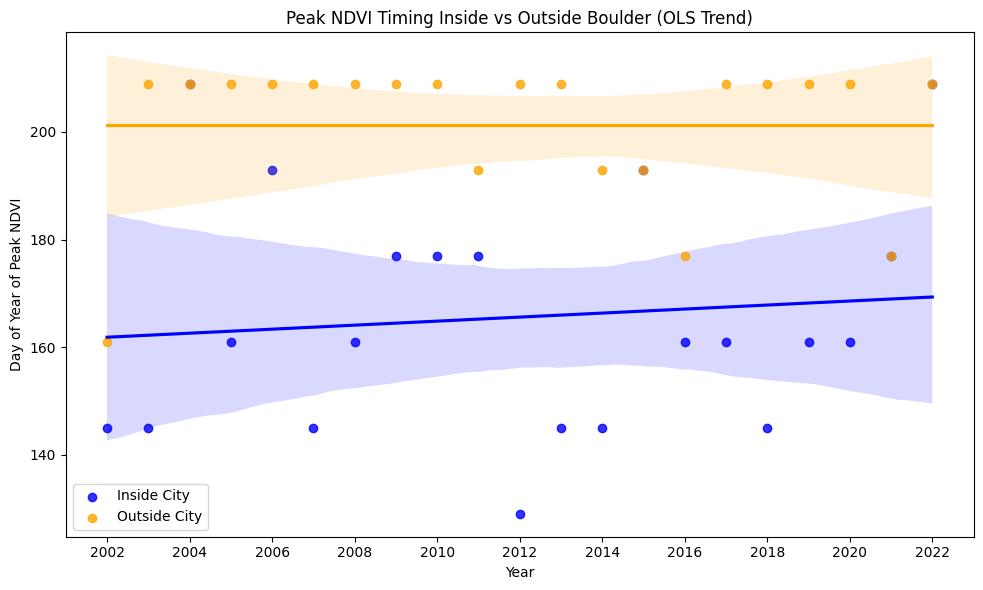

In [19]:

plt.figure(figsize=(10,6))

# Inside - blue
sns.regplot(
    x=df_in["year"],
    y=df_in["doy_inside"],
    scatter_kws={"color": "blue"},
    line_kws={"color": "blue"},
    label="Inside City"
)

# Outside - orange
sns.regplot(
    x=df_out["year"],
    y=df_out["doy_outside"],
    scatter_kws={"color": "orange"},
    line_kws={"color": "orange"},
    label="Outside City"
)

plt.title("Peak NDVI Timing Inside vs Outside Boulder (OLS Trend)")
plt.xlabel("Year")
plt.ylabel("Day of Year of Peak NDVI")
plt.legend()
plt.tight_layout()

# Force x-axis ticks to be integers
plt.xticks(np.arange(df_peaks["year"].min(), df_peaks["year"].max()+1, 2))

plt.show()

In [20]:


# X = year as 2D array
X = df_peaks["year"].values.reshape(-1, 1)
y = df_peaks["doy_inside"].values

# Fit the model
model = LinearRegression()
model.fit(X, y)

# Predicted trend line
df_peaks["trend_inside"] = model.predict(X)


plot = (
    df_peaks.hvplot.scatter(
        x="year", y="doy_inside",
        title="Peak NDVI Day-of-Year — Inside Boulder",
        color="blue", size=8, alpha=0.7, label="Observed"
    )
    * df_peaks.hvplot.line(
        x="year", y="doy_inside",
        color="lightblue", line_width=2, label="Observed Line"
    )
    * df_peaks.hvplot.line(
        x="year", y="trend_inside",
        color="darkblue", line_width=3, line_dash='dashed', label="Trend Line"
    )
)

plot

:Overlay
   .Scatter.Observed    :Scatter   [year]   (doy_inside)
   .Curve.Observed_Line :Curve   [year]   (doy_inside)
   .Curve.Trend_Line    :Curve   [year]   (trend_inside)